In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from scipy.fft import fft, fftfreq

### Подготовка данных и определение вспомогательных функций

In [211]:
train = pd.read_csv('train.csv')
k = train.k
x = train.x

In [212]:
def model(k, a, omega, phi, b, c):
    return a * np.sin(omega * k + phi) + b * k + c


def loss(params):
    a, omega, phi, b, c = params
    y_pred = model(k, a, omega, phi, b, c)
    return np.mean((x - y_pred)**2)

### Реализация автоматического подбора начальных значений параметров

Разделим уравнение модели условно на линейный тренд $(b * k + c)$ и синусоиду $a * sin(\omega k + \varphi)$
Сначала оценим $b$ и $c$ с помощью линейной регрессии

In [213]:
X_lin = np.array(k)
X_lin.shape = (100, 1)
y = x.copy()

lin_reg = LinearRegression()
lin_reg.fit(X_lin, y)

b = lin_reg.coef_[0]
c = lin_reg.intercept_

# Удаление тренда
residual = y - (b * k + c)

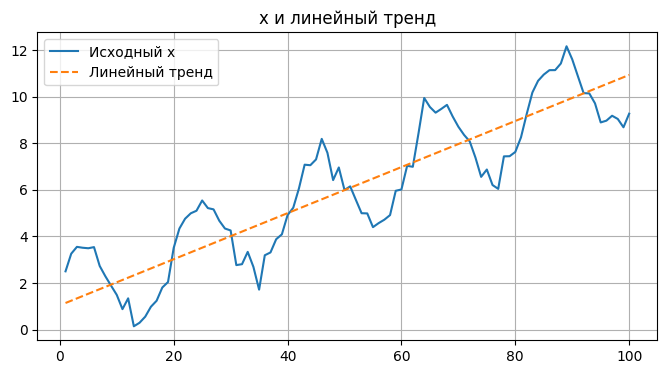

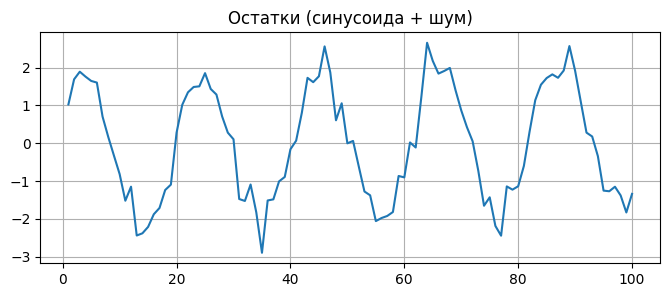

In [243]:
plt.figure(figsize=(8, 4))
plt.plot(k, x, label='Исходный x')
plt.plot(k, b * k + c, label='Линейный тренд', linestyle='--')
plt.title('x и линейный тренд')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(k, residual, label='Остатки после вычитания тренда')
plt.title('Остатки (синусоида + шум)')
plt.grid()
plt.show()

С помощью преобразования Фурье найдем приближенное значение частоты $\omega$

Для этого вычисляем спектр амплитуд с помощью функции $fft()$ (преобразование Фурье), далее генерируем частоты с помощью $fftfreq()$

И находим пиковую частоту f, которая связана с $\omega$ через $\omega = 2\pi f$

In [214]:
dt = 1 # шаг
n = len(k)

fft_vals = fft(residual)
freqs = fftfreq(n, d=dt)

positive_freqs = freqs[:n // 2]
magnitudes = np.abs(fft_vals[:n // 2])
peak_idx = np.argmax(magnitudes[1:]) + 1

# Оценка омега
omega = 2 * np.pi * positive_freqs[peak_idx]

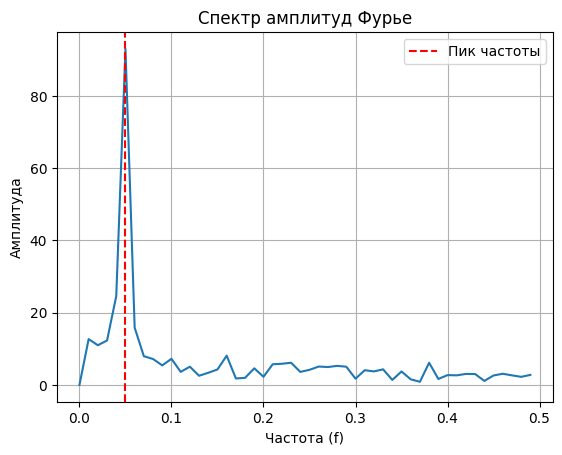

In [215]:
# Визуализация
plt.plot(positive_freqs, magnitudes)
plt.title("Спектр амплитуд Фурье")
plt.xlabel("Частота (f)")
plt.ylabel("Амплитуда")
plt.axvline(positive_freqs[peak_idx], color='red', linestyle='--', label='Пик частоты')
plt.legend()
plt.grid()
plt.show()

Произведем тригонометрическое преобразование $a * sin(\omega k + \varphi) = A * sin(\omega k) + B * cos(\omega k)$, где

$A = a * cos(\varphi)$
$B = a * sin(\varphi)$

Далее с помощью линейной регрессии оценим А и B

In [216]:
sin_wk = np.sin(omega * k)
cos_wk = np.cos(omega * k)

X_trig = np.column_stack([sin_wk, cos_wk])
lin_trig = LinearRegression()
lin_trig.fit(X_trig, residual)

A, B = lin_trig.coef_

# Восстановим a и phi
a = np.sqrt(A**2 + B**2)
phi = np.arctan2(B, A)

### Применим нелинейную оптимизацию для точной оценки всех парметров

In [217]:
params = [a, omega, phi, b, c]
result = minimize(loss, params, method='L-BFGS-B')
a, omega, phi, b, c = result.x

In [218]:
print("Оценённые параметры:")
print(f"a     = {a:.4f}")
print(f"omega = {omega:.4f}")
print(f"phi   = {phi:.4f}")
print(f"b     = {b:.4f}")
print(f"c     = {c:.4f}")
print(f"Значение среднеквадратичной ошибки: {loss([a, omega, phi, b, c])}")

Оценённые параметры:
a     = 2.0070
omega = 0.3009
phi   = 0.4520
b     = 0.0989
c     = 1.0428
Значение среднеквадратичной ошибки: 0.10546035211251203


In [220]:
mse = loss([a, omega, phi, b, c])
var = np.var(x)
r2 = 1 - mse / var

print(f"MSE: {mse:.6f}")
print(f"Variance: {var:.6f}")
print(f"R²: {r2:.4f}")

MSE: 0.105460
Variance: 9.239263
R²: 0.9886


### Применяем модель к тестовым данным

In [237]:
test = pd.read_csv('test.csv')
X = test.k

In [238]:
prediction = model(X, a, omega, phi, b, c)
test['x'] = prediction
test.to_csv('pred.csv')